In [2]:
import sys, os

import pandas as pd
pd.set_option('display.max_rows', 10, 'display.max_columns', 99)

import scipy as sp
from scipy.sparse import csr_matrix

import scanpy as sc
sc.set_figure_params(format='png')

In [30]:
#Load RNA data
rna = sc.read_csv('./data/CITEseq/working/GSE100866_CBMC_8K_13AB_10X-RNA_umi.csv').T
rna

AnnData object with n_obs × n_vars = 8617 × 36280 

In [31]:
#Load protein data -- each of these could be interchangeable as just "data.1", "data.2", etc.
protein = sc.read_csv('./data/CITEseq/working/GSE100866_CBMC_8K_13AB_10X-ADT_clr-transformed.csv').T
protein

AnnData object with n_obs × n_vars = 8617 × 13 

In [36]:
#Find neighbors for data.2 (protein) and add to anndata object BEFORE running scanpy umap function
sc.pp.neighbors(protein, n_neighbors=30)

In [37]:
#Build UMAP with data.2 (protein)
sc.tl.umap(protein, 
           min_dist=0.0,
           n_components=2, 
           init_pos='spectral', 
           random_state=42)

In [38]:
#Use louvain clustering with data.2 (protein)
sc.tl.louvain(protein, resolution=0.5)

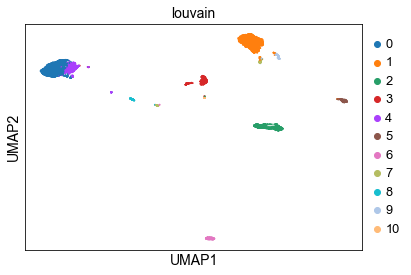

In [39]:
#Plot data in UMAP layout, colored by louvain clusters
sc.pl.umap(protein, color='louvain')

In [29]:
#RNA requires some pre-processing
#FILTERING OUT ZERO CELLS/FEATURES
def filterData(ad, cell_count, prop_cells):
    
    #remove cells that have very few counts
    sc.pp.filter_cells(ad, min_counts=cell_count, inplace=True)
    
    #remove genes that aren't present in at least X% of cells
    #prop_cells=0.2
    num_cells = int(prop_cells*rna.shape[0])
    sc.pp.filter_genes(ad, min_cells=num_cells, inplace=True)
    
    return ad
filterData(rna, cell_count=10, prop_cells=0.2)

AnnData object with n_obs × n_vars = 8617 × 1120 
    obs: 'louvain', 'protein_clusterIDs', 'n_counts'
    var: 'n_cells'
    uns: 'neighbors', 'louvain', 'louvain_colors', 'protein_clusterIDs_colors'
    obsm: 'X_pca', 'X_umap'

         Falling back to preprocessing with `sc.pp.pca` and default params.


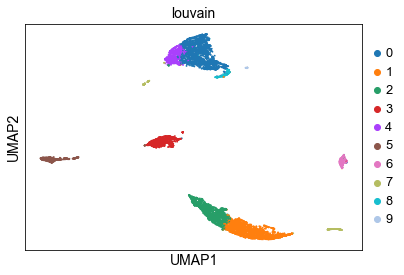

In [40]:
#Repeat same steps for other data modality, rna in this case
#Find neighbors for data.2 (protein) and add to anndata object BEFORE running scanpy umap function
sc.pp.neighbors(rna, n_neighbors=30)
#Build UMAP with data.2 (protein)
sc.tl.umap(rna, 
           min_dist=0.0,
           n_components=2, 
           init_pos='spectral', 
           random_state=42)
#Use louvain clustering with data.2 (protein)
sc.tl.louvain(rna, resolution=0.5)
#Plot data in UMAP layout, colored by louvain clusters
sc.pl.umap(rna, color='louvain')

In [41]:
from sklearn.metrics import adjusted_rand_score

In [42]:
#assess similarity of clusterings using adjusted rand index
ars = adjusted_rand_score(protein.obs['louvain'], rna.obs['louvain'])

In [43]:
ars

0.5129995169617966

In [44]:
#add cluster ids from one data type clustering to other anndata object, for each data type
#color layout by other data type cluster ids
protein.obs['rna_clusterIDs'] = rna.obs['louvain']
rna.obs['protein_clusterIDs'] = protein.obs['louvain']

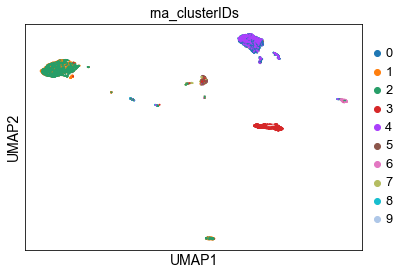

In [25]:
#Now plot data in UMAP layout again, 
#but colored by louvain cluster IDs from clustering 
#based on other data type as features
#Here, protein layout colored by rna clusters
sc.pl.umap(protein, color='rna_clusterIDs')

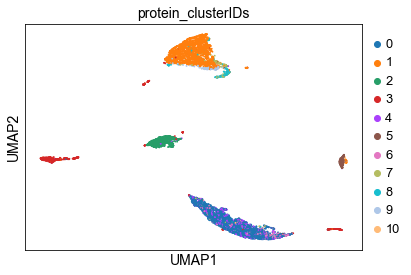

In [26]:
#Here, rna layout colored by protein clusters
sc.pl.umap(rna, color='protein_clusterIDs')

In [45]:
#function to do this, allowing for different data types, layouts, and clustering algorithm
#filter rna via same method as in original CITE-seq paper
from statsmodels.nonparametric.smoothers_lowess import lowess
filtered = lowess(measurements, input_range, frac=0.05)

In [ ]:
#make a function to do this, 
#allowing for different data types, layouts, and clustering algorithms